In [3]:
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt, animation
from PIL import Image
from matplotlib.colors import ListedColormap

In [22]:
class BurningForest():
    # 0 - empty, 1 - occupied, -1 - burning, 2 - burned
    # windStrength in [0, 2], 

    def __init__(self, L, wind=False, windStrength=0):
        self.L = L
        self.forest = np.zeros((L, L))
        self.burning = []
        
        self.windDirection = wind
        self.windStrength = windStrength
        
        self.allLabels = np.arange(L*L)
    
    def initiateForest(self, p):
        self.forest = np.zeros((self.L, self.L))
        for i in range(self.L):
            for j in range(self.L):
                if np.random.uniform() < p:
                    self.forest[i, j] = 1
                    
    def getNeighbors(self, position):
        i = position[0]
        j = position[1]
        if i == 0 and j == 0:
            return [(i+1, j), (i, j+1), (i+1, j+1)]
        elif i == 0:
            return [(i+1, j), (i, j+1), (i, j-1), (i+1, j-1), (i+1, j+1)]
        elif i == self.L-1 and j == 0:
            return [(i-1, j), (i, j+1), (i-1, j+1)]
        elif i == self.L-1:
            return [(i-1, j-1), (i-1, j), (i, j+1), (i, j-1), (i-1, j+1)]
        elif j == 0:
            return [(i-1, j), (i+1, j), (i, j+1), (i-1, j+1), (i+1, j+1)]
        return [(i-1, j-1), (i-1, j), (i+1, j), (i, j+1), (i, j-1), (i-1, j+1), (i+1, j-1), (i+1, j+1)]
    
    def initiateFire(self):
        for i in range(self.L):
            state = self.forest[i, 0]
            if state == 1:
                self.forest[i, 0] = -1
                self.burning.append((i, 0))
        
    def simulateFire(self):
        self.initiateFire()
        
        fireOngoing = True
        burningTrees = []
        while fireOngoing:
            for tree in self.burning:
                neighbors = self.getNeighbors(tree)
                for neighbor in neighbors:
                    i, j = neighbor
                    if j >= self.L:
                        return 1
                    if self.forest[i, j] == 1:
                        self.forest[i, j] = -1
                        burningTrees.append((i, j))
                        if j >= self.L - 1:
                            return 1
                self.forest[tree[0], tree[1]] = 2
            self.burning = burningTrees
            burningTrees = []
            if len(self.burning) == 0:
                fireOngoing = False
        return 0
    
    def performBurning(self, numberOfSimulations=100, wind=False):
        ps = np.arange(0.01, 1, 0.01)
        res = np.zeros(len(ps))
        for p in range(len(ps)):
            for i in range(numberOfSimulations):
                self.initiateForest(ps[p])
                if (not wind): 
                    res[p] += self.simulateFire()
                else:
                    res[p] += self.simulateFireWithWind()
            res[p] /= numberOfSimulations
        return res
    
    def simulateFireWithResultsSave(self):
        self.initiateFire()

        fireStates = self.forest

        fireOngoing = True
        burningTrees = []
        while fireOngoing:
            fireStates = np.vstack([fireStates, self.forest])
            for tree in self.burning:
                neighbors = self.getNeighbors(tree)
                for neighbor in neighbors:
                    i, j = neighbor
                    if self.forest[i, j] == 1:
                        self.forest[i, j] = -1
                        burningTrees.append((i, j))
                        if j >= self.L-1:
                            fireOngoing = False
                self.forest[tree[0], tree[1]] = 0
            self.burning = burningTrees
            burningTrees = []

            if len(self.burning) == 0:
                fireOngoing = False
        fireStates = np.vstack([fireStates, self.forest])
        return fireStates
    
    def getSusceptibleAndLessSusceptibleNeighbors(self, position):
        i = position[0]
        j = position[1]
        allNeighbors = self.getNeighbors(position)
        uniqueI = set([pos[0] for pos in allNeighbors])
        uniqueJ = set([pos[1] for pos in allNeighbors])
        if (not self.windDirection):
            return allNeighbors, []
        else:
            if self.windDirection == 'N':
                susceptible = [pos for pos in allNeighbors if pos[0] != i+1]
                if self.windStrength >= 1 and i < self.L - 2:
                    nextSusceptible = [(i+2, newJ) for newJ in uniqueJ]
                    susceptible = susceptible + nextSusceptible
                lessSusceptible = [pos for pos in allNeighbors if pos not in susceptible]
            elif self.windDirection == 'S':
                susceptible = [pos for pos in allNeighbors if pos[0] != i-1]
                if self.windStrength >= 1 and i > 2:
                    nextSusceptible = [(i-2, newJ) for newJ in uniqueJ]
                    susceptible = susceptible + nextSusceptible
                lessSusceptible = [pos for pos in allNeighbors if pos not in susceptible]
                if self.windStrength > 1:
                    lessSusceptible = []
            elif self.windDirection == 'E':
                susceptible = [pos for pos in allNeighbors if pos[1] != j-1]
                if self.windStrength >= 1 and j > 2:
                    nextSusceptible = [(newI, j-2) for newI in uniqueI]
                    susceptible = susceptible + nextSusceptible
                lessSusceptible = [pos for pos in allNeighbors if pos not in susceptible]
            elif self.windDirection == 'W':
                susceptible = [pos for pos in allNeighbors if pos[1] != j+1]
                if self.windStrength >= 1 and j < self.L - 2:
                    nextSusceptible = [(newI, j+2) for newI in uniqueI]
                    susceptible = susceptible + nextSusceptible
                lessSusceptible = [pos for pos in allNeighbors if pos not in susceptible]
            else:
                raise Exception(f"Wind cannot take value: {wind}. Please use value from: [False, 'W', 'S', 'E', 'N']")
        return susceptible, lessSusceptible

    
    def simulateFireWithWind(self):
        self.initiateFire()

        fireOngoing = True
        burningTrees = []
        while fireOngoing:
            for tree in self.burning:
                susceptible, lessSusceptible = self.getSusceptibleAndLessSusceptibleNeighbors(tree)
                allNeighbors = susceptible + lessSusceptible
                for neighbor in allNeighbors:
                    i, j = neighbor
                    if j >= self.L:
                        return 1
                    if self.forest[i, j] == 1:
                        if (neighbor in susceptible) or (neighbor in lessSusceptible and np.random.uniform() < (1-self.windStrength)):
                            self.forest[i, j] = -1
                            burningTrees.append((i, j))
                self.forest[tree[0], tree[1]] = 0
            self.burning = burningTrees
            burningTrees = []
            if len(self.burning) == 0:
                fireOngoing = False
            elif any(pos[1] >= self.L - 1 for pos in self.burning):
                return 1
        return 0
    
    def simulateFireWithWindAndResultSave(self):
        self.initiateFire()
        fireStates = self.forest
        fireOngoing = True
        burningTrees = []
        while fireOngoing:
            fireStates = np.vstack([fireStates, self.forest])
            for tree in self.burning:
                susceptible, lessSusceptible = self.getSusceptibleAndLessSusceptibleNeighbors(tree)
                allNeighbors = susceptible + lessSusceptible
                for neighbor in allNeighbors:
                    i, j = neighbor
                    if j >= self.L:
                        return 1
                    if self.forest[i, j] == 1:
                        if (neighbor in susceptible) or (neighbor in lessSusceptible and np.random.uniform() < (1-self.windStrength)):
                            self.forest[i, j] = -1
                            burningTrees.append((i, j))
                self.forest[tree[0], tree[1]] = 0
            self.burning = burningTrees
            burningTrees = []
            if len(self.burning) == 0 or any(pos[1] >= self.L - 1 for pos in self.burning):
                fireOngoing = False
        fireStates = np.vstack([fireStates, self.forest])
        return fireStates
    
    def getNeighborsForHK(self, pos):
        i = pos[0]
        j = pos[1]
        allNeighbors = self.getNeighbors(pos)
        HKNeighbors = [neighbor for neighbor in allNeighbors if (neighbor[1] != j+1) and neighbor != (i+1, j)]
        return HKNeighbors
    
    def find(self, label):
        labelCopy = label
        
        while self.allLabels[labelCopy] != labelCopy:
            labelCopy = self.allLabels[labelCopy]   
        while self.allLabels[label] != label:
            newLabel = self.allLabels[label]
            self.allLabels[label] = labelCopy
            label = newLabel       
        return labelCopy
    
    def union(self, label1, label2):
        self.allLabels[self.find(label1)] = self.find(label2)    

    def hoshen_kopelman(self): 
        largestLabel = 0
        labels = np.zeros((self.L, self.L), dtype=int)
        for col in range(self.L):
            for row in range(self.L):  
                if self.forest[row, col] == 2:
                    neighbors = self.getNeighborsForHK((row, col))
                    neighborLabels = [labels[pos[0], pos[1]] for pos in neighbors if labels[pos[0], pos[1]] != 0]

                    if len(neighborLabels) != 0:
                        min_label = min(neighborLabels)
                        labels[row, col] = min_label
                        for label in neighborLabels:
                            if label != min_label:
                                self.union(label, min_label) 
                    else:
                        largestLabel += 1
                        labels[row, col] = largestLabel
        nums, counts = np.unique(labels, return_counts=True)
        clusters = dict(zip(nums, counts))
        
        if 0 in clusters:
            clusters.pop(0)
        if len(clusters) == 0:
            return 0
        return max(clusters.values())

In [23]:
def animateFire(data, gif_name="anim"):
    fig = plt.figure()
    sns.heatmap(data[0], vmax=.8, square=True, cbar=False, cmap=ListedColormap(['red', 'black', 'green']), yticklabels=False, xticklabels=False)

    def init():
        sns.heatmap(data[0], vmax=.8, square=True, cbar=False, cmap=ListedColormap(['red', 'black', 'green']), yticklabels=False, xticklabels=False)

    def animate(i):
        sns.heatmap(data[i], vmax=.8, square=True, cbar=False, cmap=ListedColormap(['red', 'black', 'green']), yticklabels=False, xticklabels=False)

    anim = animation.FuncAnimation(fig, animate, init_func=init, frames=len(data), repeat = False)
    anim.save(f'images/{gif_name}.gif')

In [24]:
def clean_results(res, L):
    new_res = list(np.zeros(int(len(res)/L-1)))
    for i in range(len(new_res)):
        new_res[i] = res[int((i+1)*L): int((i+2)*L)]
    return new_res

## Animations

In [74]:
ps = [0.3, 0.5, 0.7, 0.99]
animNames = ["anim03", "anim05", "anim07", "anim099"]

MovieWriter ffmpeg unavailable; using Pillow instead.
MovieWriter ffmpeg unavailable; using Pillow instead.
MovieWriter ffmpeg unavailable; using Pillow instead.
MovieWriter ffmpeg unavailable; using Pillow instead.


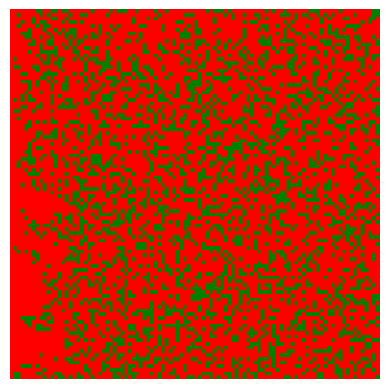

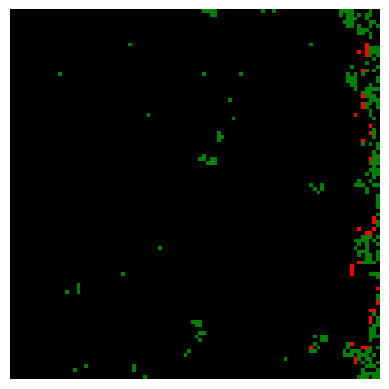

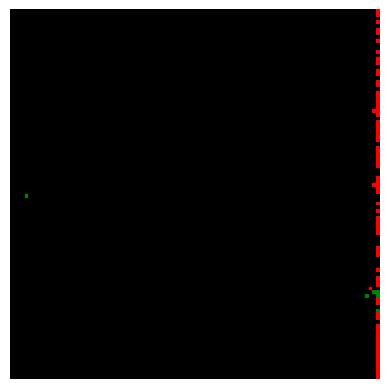

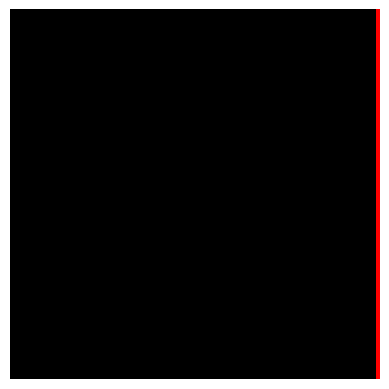

In [75]:
for i in range(len(animPs)):
    BF = BurningForest(100)
    BF.initiateForest(ps[i])
    result = BF.simulateFireWithResultsSave()
    cleanResult = clean_results(result, 100)
    animateFire(cleanResult, animNames[i])

## Animation with wind

In [15]:
ps = [0.3, 0.6, 0.99]
winds = ['W', 'S', 'E']
windStrength = 0.8
animNames = ["anim03", "anim05", "anim07", "anim099"]

MovieWriter ffmpeg unavailable; using Pillow instead.


W


MovieWriter ffmpeg unavailable; using Pillow instead.


S


MovieWriter ffmpeg unavailable; using Pillow instead.


E


MovieWriter ffmpeg unavailable; using Pillow instead.


W
S


MovieWriter ffmpeg unavailable; using Pillow instead.


E


MovieWriter ffmpeg unavailable; using Pillow instead.


W


MovieWriter ffmpeg unavailable; using Pillow instead.


S


MovieWriter ffmpeg unavailable; using Pillow instead.


E


MovieWriter ffmpeg unavailable; using Pillow instead.


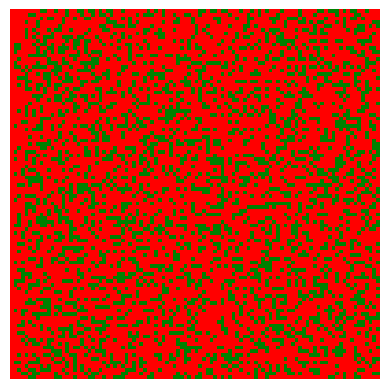

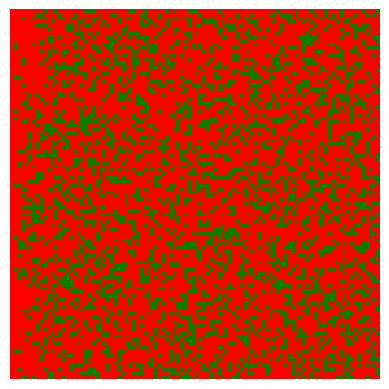

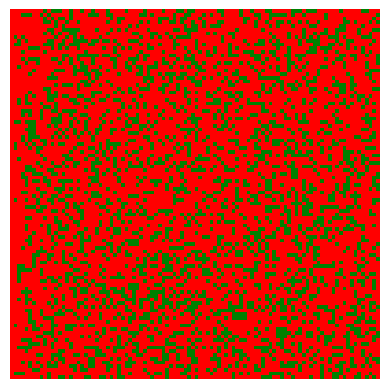

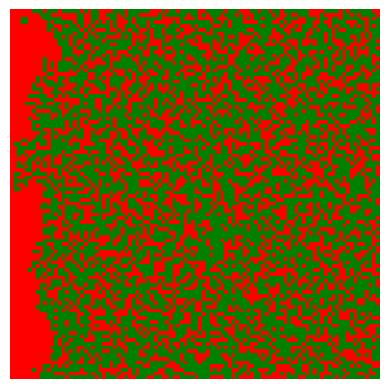

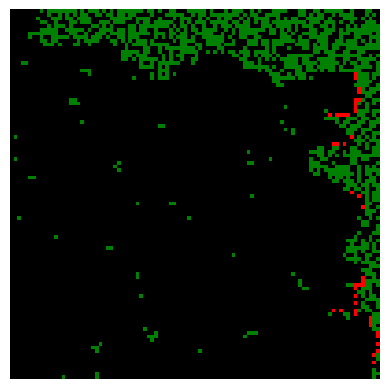

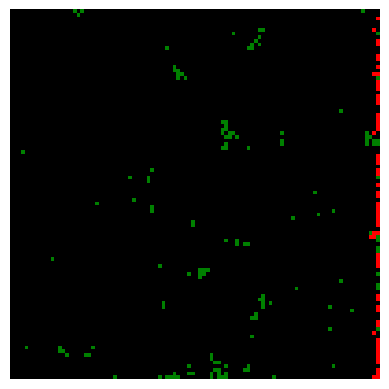

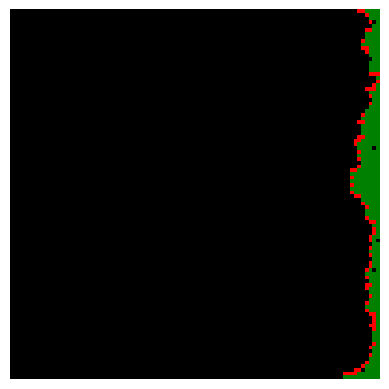

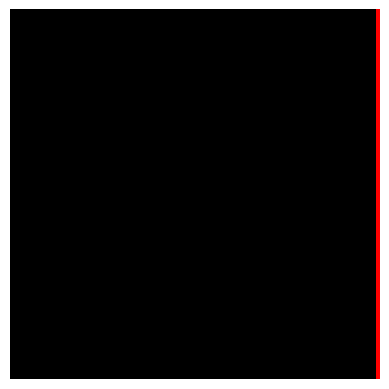

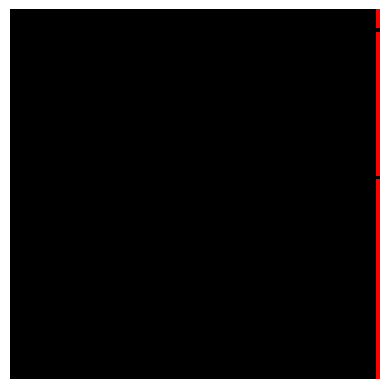

In [16]:
for i, p in enumerate(ps):
    for j, wind in enumerate(winds):
        print(wind)
        BF = BurningForest(100, wind, windStrength)
        BF.initiateForest(ps[i])
        result = BF.simulateFireWithWindAndResultSave()
        cleanResult = clean_results(result, 100)
        animateFire(cleanResult, f"{animNames[i]}_{wind}")

## Percolation threshold

In [88]:
Ls = [20, 50, 100]
percolationThreshold = list(np.zeros(len(Ls)))
ps = np.arange(0.01, 1, 0.01)
N = 100
markers = ['D', '*', 'o']

In [91]:
for i in range(len(Ls)):
    BF = BurningForest(Ls[i])
    percolationThreshold[i] = BF.performBurning(N)

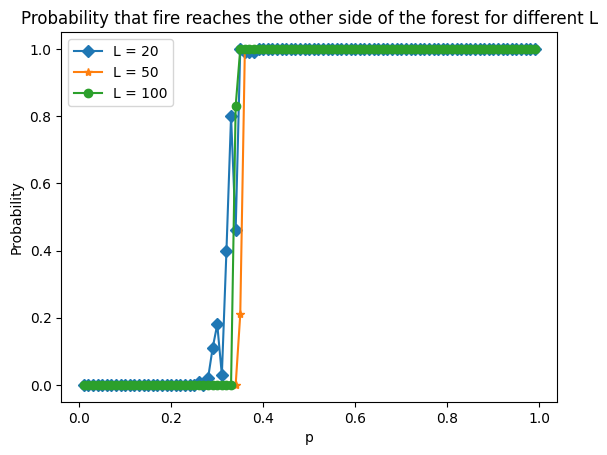

In [92]:
for i in range(len(Ls)):
    plt.plot(ps, percolationThreshold[i], label=f"L = {Ls[i]}", marker=markers[i])
plt.legend()
plt.title("Probability that fire reaches the other side of the forest for different L")
plt.xlabel("p")
plt.ylabel("Probability")
plt.savefig('images/percolationThreshold.png')

## Percolation threshold with wind 

In [96]:
windDirections = ['W', 'S', 'E', 'N']
L = 20
ps = np.arange(0.01, 1, 0.01)

#### wind strength = 0.7

In [102]:
windStrength1 = 0.7

In [103]:
percolationThresholdWind1 = list(np.zeros(len(windDirections)))
N = 100
markers = ['D', '*', 'o', '+']

In [104]:
for i in range(len(windDirections)):
    BF = BurningForest(100, windDirections[i], windStrength1)
    percolationThresholdWind1[i] = BF.performBurning(N, True)

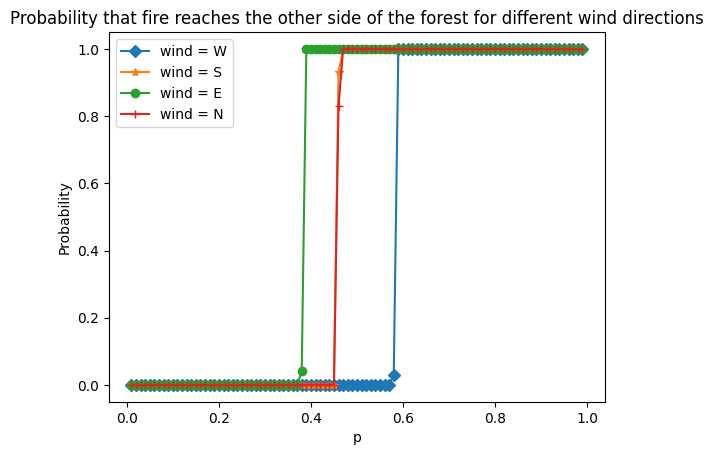

In [105]:
for i in range(len(windDirections)):
    plt.plot(ps, percolationThresholdWind1[i], label=f"wind = {windDirections[i]}", marker=markers[i])
plt.legend()
plt.title("Probability that fire reaches the other side of the forest for different wind directions")
plt.xlabel("p")
plt.ylabel("Probability")
plt.savefig('images/percolationThresholdWind1.png')

#### wind strength = 1.2

In [106]:
windStrength2 = 1.2

In [107]:
percolationThresholdWind2 = list(np.zeros(len(windDirections)))
N = 100
markers = ['D', '*', 'o', '+']

In [108]:
for i in range(len(windDirections)):
    BF = BurningForest(100, windDirections[i], windStrength2)
    percolationThresholdWind2[i] = BF.performBurning(N, True)

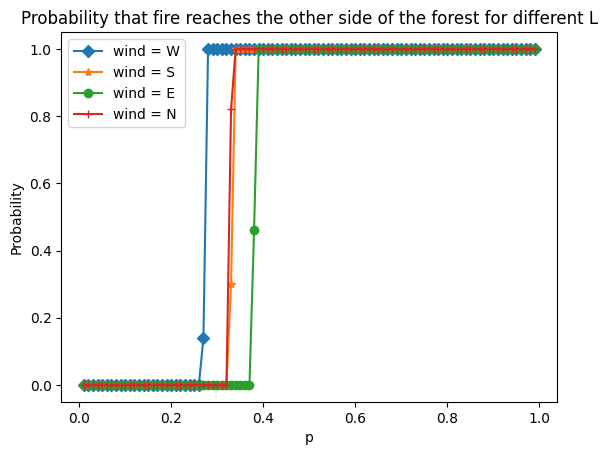

In [109]:
for i in range(len(windDirections)):
    plt.plot(ps, percolationThresholdWind2[i], label=f"wind = {windDirections[i]}", marker=markers[i])
plt.legend()
plt.title("Probability that fire reaches the other side of the forest for different L")
plt.xlabel("p")
plt.ylabel("Probability")
plt.savefig('images/percolationThresholdWind2.png')

## Average biggest cluster

In [85]:
N = 100
ps = np.arange(0.01, 1, 0.01)
biggestCluster = np.zeros(len(ps))

In [86]:
for i, p in enumerate(ps):
    for j in range(N):
        BF = BurningForest(100)
        BF.initiateForest(p)
        BF.simulateFire()
            
        biggestCluster[i] += BF.hoshen_kopelman()
        
    biggestCluster[i] /= N

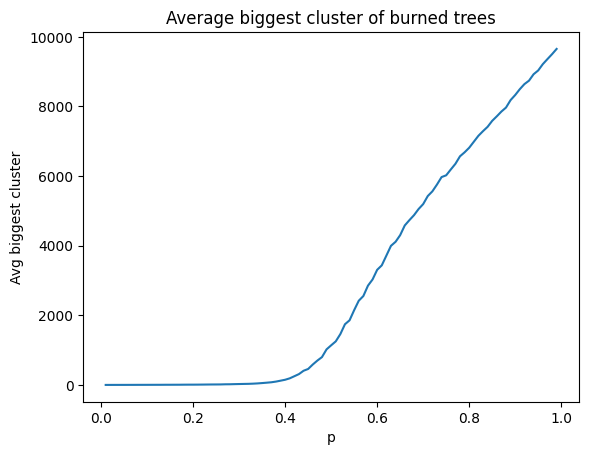

In [87]:
plt.plot(ps, biggestCluster)
plt.xlabel("p")
plt.title("Average biggest cluster of burned trees")
plt.ylabel("Avg biggest cluster")
plt.savefig('images/avgBiggestCluster.png')